In [1]:
import pandas as pd
from dbgsom.dbgsom_ import DBGSOM
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import minmax_scale, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.impute import KNNImputer
from skimage.color import lab2rgb


In [2]:
data = pd.read_csv(
    "F:\Dokumente\git\data\CIC-Darknet2020\Darknet.CSV",
    index_col="Flow ID",
    parse_dates=["Timestamp"],
)


In [3]:
# Clean up data
data.replace(
    {
        -np.inf: -1000,
        np.inf: 1000,
        "AUDIO-STREAMING": "Audio-Streaming",
        "File-transfer": "File-Transfer",
        "Video-streaming": "Video-Streaming",
    },
    inplace=True,
)
# convert timestamp to integer
data.Timestamp = data.Timestamp.astype("int64")
X = data.drop(columns=["Label", "Label.1"])
y_1 = data["Label"]
y_2 = data["Label.1"]

X_train, X_test, y_1_train, y_1_test, y_2_train, y_2_test = train_test_split(
    X, y_1, y_2, random_state=23, stratify=y_2
)


In [4]:
scaler = PowerTransformer()
imputer = KNNImputer(add_indicator=True)
# One hot encode categorical columns 
ohe = OneHotEncoder(max_categories=10, handle_unknown="infrequent_if_exist")
col_transformer = ColumnTransformer(
    transformers=[
        ("ohe", ohe, ["Src IP", "Src Port", "Dst IP", "Dst Port", "Protocol"])
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
som = DBGSOM(
    max_epochs=500,
    random_state=32,
    spreading_factor=1.5,
    max_neurons=500,
    growth_criterion="entropy",
)

pipe = Pipeline(
    steps=[
        ("col_transformer", col_transformer),
        ("scaler", scaler),
        ("imputer", imputer),
        ("som", som),
    ]
)

# y_train = y_1_train
y_train = y_2_train


In [5]:
pipe.fit(X_train, y_train)


c:\tools\miniconda3\envs\py39_dbgsom\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
 64%|██████▎   | 318/500 [03:01<01:43,  1.75 epochs/s]


Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                max_categories=10),
                                                  ['Src IP', 'Src Port',
                                                   'Dst IP', 'Dst Port',
                                                   'Protocol'])],
                                   verbose_feature_names_out=False)),
                ('scaler', PowerTransformer()),
                ('imputer', KNNImputer(add_indicator=True)),
                ('som',
                 DBGSOM(growth_criterion='entropy', max_epochs=500,
                        max_neurons=500, random_state=32,
                        spreading_factor=1.5))])

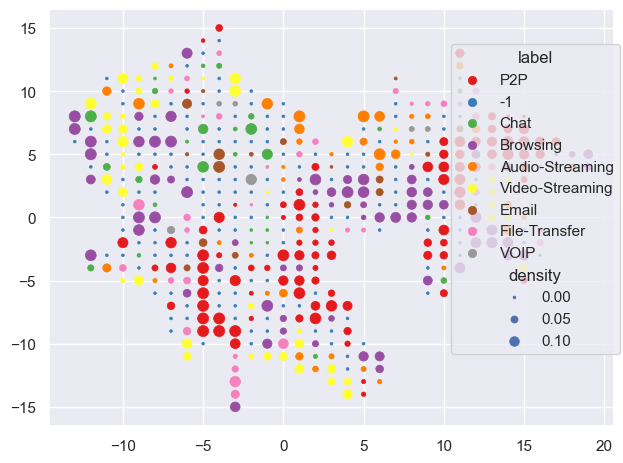

In [6]:
som.plot(
    color="label",
    palette="Set1",
    pointsize="density",
)


In [7]:
weights = som.weights_

weights_split = pd.DataFrame((pd.Series(feature) for feature in weights)).drop(
    120, axis=1
)
# Add feature names as columns
weights_split.columns = col_transformer.get_feature_names_out()


In [8]:
pca = PCA(n_components=3)
pca_components = pca.fit_transform(
    X=weights_split,
)


In [9]:
# L*a*b* is better suited to display distances 
# between colors. Thats why we convert to rgb only later.
# Reference: Cluster coloring of the Self-Organizing Map: An information visualization perspective
# Peter Sarlin and Samuel Rönnqvist


colors_lab = np.copy(pca_components)

# colors_lab[:, 0] = minmax_scale(colors_lab[:, 0], (10, 90))
# colors_lab[:, 1] = minmax_scale(colors_lab[:, 1], (-128, 127))
# colors_lab[:, 2] = minmax_scale(colors_lab[:, 2], (-128, 127))


colors_lab[:, 0] = minmax_scale(colors_lab[:, 0], (10, 90))
colors_lab[:, 1] = minmax_scale(colors_lab[:, 1], (-45, 45))
colors_lab[:,2] = colors_lab[:, 1]


# colors_lab[:, 0] = minmax_scale(colors_lab[:, 0], (10, 90))
# colors_lab[:, 1] = minmax_scale(colors_lab[:, 1], (-60, 60))
# colors_lab[:,2] = 40

colors_rgb = lab2rgb(colors_lab)


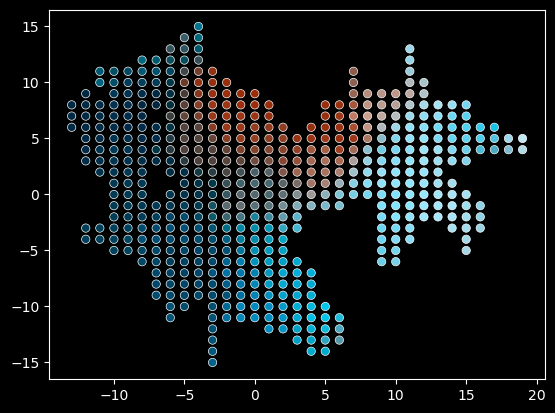

In [10]:
sns.scatterplot(
    x=np.array(som.som_.nodes)[:, 0],
    y=np.array(som.som_.nodes)[:, 1],
    color=colors_rgb,
)
plt.savefig("darknet_pca", dpi=300)



In [11]:
print(f"Topographic error: {som.topographic_error_}")

print(f"Accuracy: {pipe.score(X_test, y_2_test)}")

print(
    f"""F1 score: {f1_score(
    y_2_test,
    pipe.predict(X_test),
    average="macro"
    )
}"""
)

print(f"Growing Threshold: {som.growing_threshold_}")


Topographic error: 0.052917180890651644
Accuracy: 0.8110109374558404
F1 score: 0.6011732613159533
Growing Threshold: 1.5


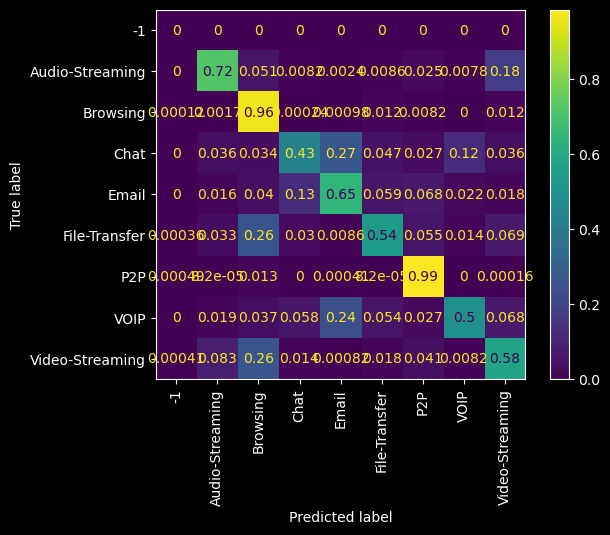

In [12]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_2_test,
    pipe.predict(X_test),
    normalize="true",
    xticks_rotation="vertical",
    # values_format="f{.3}"
)
